### Notes

* Script for developing the speaker recognition model
* I built it up as I went along, training in the notebook
* Then switched the code to a function and ran it from the notebook

29-Jun-18: Last used it today to prepare for Mark Herbster meeting

06-Jul-18: Took a copy so I can work on improving the network. I want to get it 'finished' so I can train it and incorporate into the evaluation metrics in the run over the weekend. Then, I'll be able to use it for the next stage of the project.

Run in '/home/ubuntu/msc-project-speaker-recognition/msc-project'
on aws-big

### TODO
* Check that everything still runs...
* Tweak the issue with the randomizing of samples
* Look at Jiameng's code for the next phase
* Finalize the architecture...
* Check into GitHub etc., move to master branch
* Build final trained model within master
* Incorporate into the evaluation metrics

In [1]:
import os
import sys

os.chdir('/home/ubuntu/msc-project-speaker-recognition/msc-project')
os.getcwd()

'/home/ubuntu/msc-project-speaker-recognition/msc-project'

In [2]:
import argparse
import visdom
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from data import NpzFolder, NpzLoader, TBPTTIter
from model import Loop, MaskedMSE
from utils import create_output_dir, wrap, check_grad

import matplotlib.pyplot as plt

import pandas as pd

import notebook_utils as nu

import speaker_recognition as sr

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### How long are the sequences in reality?

In [3]:
train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk' + '/numpy_features', False)
train_loader = NpzLoader(train_dataset,
                         max_seq_len=1000,
                         batch_size=1e5,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [50]:
epoch = 1
valid_enum = tqdm(train_loader, desc='Valid epoch %d' % epoch)
for txt, feat, spkr in valid_enum:
    #input = wrap(txt, volatile=True)
    #target = wrap(feat, volatile=True)
    #spkr = wrap(spkr, volatile=True)
    
    break



Valid epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]


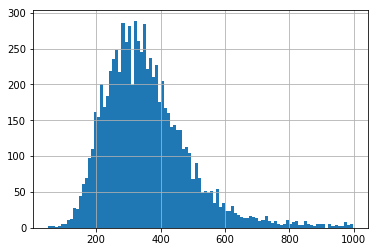

In [66]:
plt.hist(feat[1].numpy(), bins=100)
plt.grid(True)
plt.show()

In [77]:
np.percentile(feat[1].numpy(), 37)

300.0

In [78]:
sample_lens = feat[1].numpy()

In [194]:
start_idx = np.zeros_like(sample_lens)

In [190]:
start_idx = [np.random.randint(i+1) for i in np.maximum(0, sample_lens - 300)]

In [199]:
feat[0][start_idx, :, :].size()

KeyboardInterrupt: 

In [204]:
len(train_dataset)

8015

In [205]:
feat[1].min()

52

In [206]:
feat[0].size()

torch.Size([997, 7839, 63])

### Train on 22 US speaker dataset
Smaller and quicker for evaluation purposes

In [4]:
net, criterion, train_losses, eval_dict = sr.train_speaker_recognition(data_path = '/home/ubuntu/loop/data/vctk',
                                                                nspk = 22,
                                                                seq_len = 300,
                                                                batch_size = 64,
                                                                num_epochs = 10,
                                                                exp_name = '20180709_us_22'
                                                                  )

Valid epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Training accuracy: 0.964


Train epoch 1:   0%|          | 0/126 [00:00<?, ?it/s]

Validation accuracy: 0.962


Valid epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Training accuracy: 0.988


Train epoch 2:   0%|          | 0/126 [00:00<?, ?it/s]

Validation accuracy: 0.983


Train (loss 0.017) epoch 2:  25%|██▍       | 31/126 [00:11<00:35,  2.69it/s]Process Process-154:
Process Process-153:
Process Process-155:
Process Process-156:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args

KeyboardInterrupt: 

In [4]:
print eval_dict['train_accuracy']
print eval_dict['valid_accuracy']

0.991580558745
0.982532751092


### Train on full VCTK-all dataset
This is the one that matters

In [3]:
net, criterion, train_losses, eval_dict = sr.train_speaker_recognition(data_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                                                                    nspk = 108,
                                                                    seq_len = 300,
                                                                    batch_size = 64,
                                                                    num_epochs = 20,
                                                                    exp_name = '20180706')

/usr/local/lib/python2.7/dist-packages/torch/backends/cudnn/__init__.py:48: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "
Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.830


Train epoch 1:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.812


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.924


Train epoch 2:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.909


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.959


Train epoch 3:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.945


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.956


Train epoch 4:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.939


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.969


Train epoch 5:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.954


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.976


Train epoch 6:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.958


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.975


Train epoch 7:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.957


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.984


Train epoch 8:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.986


Train epoch 9:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.971


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.980


Train epoch 10:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.965


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.985


Train epoch 11:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.968


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.988


Train epoch 12:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.972


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.987


Train epoch 13:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.984


Train epoch 14:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.969


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.989


Train epoch 15:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.972


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.991


Train epoch 16:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.978


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.987


Train epoch 17:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.972


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.987


Train epoch 18:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.987


Train epoch 19:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.975


Valid epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy: 0.992


Valid epoch 19:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.980


Evaluation (loss 0.03) epoch 19: 100%|██████████| 68/68 [00:04<00:00, 16.39it/s]


In [4]:
eval_dict.keys()

['train_loss',
 'valid_accuracy',
 'valid_gt',
 'valid_loss',
 'train_accuracy',
 'valid_correct',
 'valid_pred']

In [5]:
eval_dict['valid_accuracy']

0.9798270893371758

In [6]:
eval_dict['train_accuracy']

0.9919871372466328

#### Error analysis

In [7]:
acc_detail = pd.DataFrame(zip(eval_dict['valid_gt'], eval_dict['valid_correct']), columns=('spkr', 'correct'))

In [8]:
print "Num errors: %d/%d" % (np.sum(eval_dict['valid_correct']==False), len(eval_dict['valid_correct']))

Num errors: 84/4164


In [9]:
df = acc_detail.groupby('spkr').aggregate(('count', 'sum', 'mean'))

In [10]:
df['correct'].sort_values('mean', ascending=True).head()

,count,sum,mean
spkr,,,
98,42,36.0,0.857143
76,41,36.0,0.878049
57,39,35.0,0.897436
86,39,35.0,0.897436
38,34,31.0,0.911765


In [24]:
train_loss=np.zeros((10,1))
valid_loss=np.zeros((10,1))
mcd=np.zeros((10,1))
train_acc=np.zeros((10,1))
valid_acc=np.zeros((10,1))

In [35]:
columns=( 'train_loss', 'valid_loss', 'mcd')

In [36]:
y = np.hstack([vars()[x] for x in columns])

In [37]:
y

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

### Notes 20180706
* Implemented randomized segment during training
    * Seems to work okay on us-22
    * Now running on vctk-all with maxpool, 300
        * Got to 98.3% on the valid set after 12 epochs and then fell back a touch in the next two (may have done better if trained for longer)
    * vctk-all with 200
        * Got to 98.4% after around 11 epochs, may have got a bit more out if trained further?
        
    * added weight_norm at the end
        * bit worse, but hard to be 100% sure
        
    * double number of conv filters in layers 3 and 4
        * Got to 100% on us-22, but was worse on vctk-all (no higher than 96%)
        
    * added dropout to all the conv layers
        * okay for us-22: slower to train, but by 10 epoch validation was 99.7%
        * for vctk-all, never gets much above 97%...
       

### TODO
* Increase epochs - any improvement? *yes, gets up to 99.9%. Didn't get rid of the last error though*
* Vary seq_len. How sensitive? *much faster on seq_len=100. Results similar in the end.*
* Run on full dataset... does it work?
* Try using random 500 step chunk of non-padded part of each sample -> much more robust?
* Then try using mean or rms rather than max, seeing as padding less of an issue?
* Then look at whether there's a relationship between the classes than come 2nd/3rd and which speaker embeddings are close based on cosine similarity

# OLD CODE
From the first iteration

## Develop the speaker recognition model

In [2]:
gpu = 0
seed = 1
data = '/home/ubuntu/loop/data/vctk'
nspk = 22
max_seq_len = 1000
seq_len = 100
batch_size = 64

In [3]:
torch.cuda.set_device(gpu)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# wrap train dataset
train_dataset = NpzFolder(data + '/numpy_features', nspk == 1)
train_loader = NpzLoader(train_dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [5]:
# wrap validation dataset
valid_dataset = NpzFolder(data + '/numpy_features_valid', nspk == 1)
valid_loader = NpzLoader(valid_dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [7]:
class RecognitionNet(nn.Module):
    def __init__(self, seq_len):
        super(RecognitionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 1 input channel, 32 output channels, 3x3 square convolution
        self.bn1 = nn.BatchNorm2d(32)
                
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.bn4 = nn.BatchNorm2d(32)
        
        self.conv5 = nn.Conv2d(32, 32, 3)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        self.fc1 = nn.Linear(1 * 32 * 53, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, nspk)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #print x.size()
        #print type(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print x.size()
        x = F.relu(self.bn2(self.conv2(x)))
        #print x.size()
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        #print x.size()
        
        # ave pooling over time
        #x = self.pool(x)
        x = torch.max(x, dim=2)[0]
        #print x.size()
        
        x = x.view(-1, self.num_flat_features(x))
        #print x.size()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def cuda(self, device_id=None):
        nn.Module.cuda(self, device_id)

In [8]:
def evaluate(net, criterion, epoch=1, eval_losses=[], loader=valid_loader):
    total = 0
    valid_enum = tqdm(loader, desc='Valid epoch %d' % epoch)
    #valid_enum = loader

    total_correct = 0.
    total_samples = 0.
    
    num_samples = len(loader.dataset)
    all_pred = []
    all_gt = []
    all_correct = []
    
    for txt, feat, spkr in valid_enum:
        input = wrap(txt, volatile=True)
        target = wrap(feat, volatile=True)
        spkr = wrap(spkr, volatile=True)

        # TODO: run with gradients turned off?
        output = net(target[0].transpose(0,1).unsqueeze(1))
        loss = criterion(output, spkr.view(-1))
        
        #output, _ = model([input, spkr], target[0])
        #loss = criterion(output, target[0], target[1])

        total += loss.data[0]

        valid_enum.set_description('Valid (loss %.2f) epoch %d' %
                                   (loss.data[0], epoch))
        
        total_samples += len(spkr)
        
        spkr_gt = spkr.cpu().view(-1).data.numpy()
        spkr_pred = output.cpu().data.numpy().argmax(1)
        
        correct_pred = spkr_gt == spkr_pred
        num_correct_pred = np.sum(correct_pred)
        total_correct += num_correct_pred
        
        all_pred.append(spkr_pred)
        all_gt.append(spkr_gt)
        all_correct.append(correct_pred)
        

    accuracy = total_correct / total_samples
            
    avg = total / len(valid_loader)
    eval_losses.append(avg)
   
    all_pred = np.concatenate(all_pred)
    all_gt = np.concatenate(all_gt)
    all_correct = np.concatenate(all_correct)
    
    return avg, accuracy, all_pred, all_gt, all_correct

In [83]:
seq_len = 300
epoch = 1
num_epochs = 5

In [84]:
net = RecognitionNet(seq_len=seq_len)
net.cuda()
net.train()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [85]:
train_losses = []
for epoch in range(num_epochs):
    train_enum = tqdm(train_loader, desc='Train epoch %d' % epoch)

    total = 0
    for full_txt, full_feat, spkr in train_enum:
        batch_iter = TBPTTIter(full_txt, full_feat, spkr, seq_len)
        batch_total = 0

        counter = 1
        for txt, feat, spkr, start in batch_iter:
            input = wrap(txt)
            target = wrap(feat)
            spkr = wrap(spkr)

            # Zero gradients
            if start:
                optimizer.zero_grad()

            # Forward
            #output = net(target[0].transpose(0,1).unsqueeze(1).cpu())
            output = net(target[0].transpose(0,1).unsqueeze(1))
            #print output.size()
            #print spkr.size()
            loss = criterion(output, spkr.view(-1))
            #print "Iteration %d: loss %.2f" %(counter, loss.data[0])

            # Backward
            loss.backward()
            #if check_grad(model.parameters(), args.clip_grad, args.ignore_grad):
            #    logging.info('Not a finite gradient or too big, ignoring.')
            #    optimizer.zero_grad()
            #    continue
            optimizer.step()


            # Keep track of loss
            batch_total += loss.data[0]
            counter += 1

            break

        batch_total = batch_total / len(batch_iter)
        total += batch_total
        train_enum.set_description('Train (loss %.3f) epoch %d' %
                                   (batch_total, epoch))
        #print "Train (loss %.2f)" % (batch_total)

        #break
    avg = total / len(train_loader)
    train_losses.append(avg)


#logging.info('====> Train set loss: {:.4f}'.format(avg))

Train (loss 0.00) epoch 4: 100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


In [86]:
train_losses

[0.3126998151943244,
 0.012177846507506843,
 0.005214821041109552,
 0.0028364011609218315,
 0.005955733493753958]

In [89]:
avg, accuracy, all_pred, all_gt, all_correct = evaluate(net, criterion, loader=valid_loader)
print "Average Loss: %.3f" % avg
print "Accuracy: %.3f" % accuracy
print "Num errors: %d/%d" % (np.sum(all_correct==False), len(all_correct))

Valid (loss 0.00) epoch 1: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s]

Average Loss: 0.009
Accuracy: 0.997
Num errors: 2/687


Quick check on the softmax outputs

In [57]:
sm = F.softmax(output, dim=1)

CORRECT
Ground truth speaker: 6
Predicted speaker: 6
Probability of predicted speaker: 0.559
Probability of correct speaker: 0.559


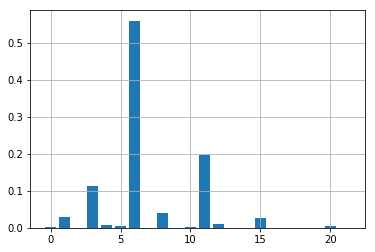

In [58]:
idx = 2

spkr_gt = spkr.cpu().view(-1).data[idx]
spkr_pred = sm[idx, :].cpu().data.numpy().argmax()

if spkr_gt == spkr_pred:
    print "CORRECT"
else:
    print "*** MISTAKE ***"
        
print "Ground truth speaker: %d" % spkr_gt
print "Predicted speaker: %d" % spkr_pred
print "Probability of predicted speaker: %0.3f" % sm[idx, :].cpu().data.numpy().max()
print "Probability of correct speaker: %0.3f" % sm[idx, spkr.cpu().view(-1).data[idx]]

plt.bar(range(nspk), sm[idx,:].cpu().data.numpy())
plt.grid(True)
plt.show()

In [36]:
accuracy

0.982532751091703

In [22]:
acc_detail = pd.DataFrame(zip(all_gt, all_correct), columns=('spkr', 'correct'))

In [116]:
#acc_detail.groupby('spkr').mean()

In [2]:
#valid_loader.dataset.speakers

In [111]:
speaker_info = nu.get_vctk_speaker_info()

In [113]:
input = Variable(torch.randn(10, 1, 28, 28))

In [114]:
output = net(input)

torch.Size([10, 1, 28, 28])
torch.Size([10, 32, 26, 26])
torch.Size([10, 32, 24, 24])
torch.Size([10, 32, 22, 22])
torch.Size([10, 22, 22])
torch.Size([10, 484])


## Using speaker_recognition module
I then moved all the code into speaker_recognition.py and trained the network from the notebook

In [7]:
net, criterion, train_losses, eval_dict = sr.train_speaker_recognition(data_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                                                                    nspk = 108,
                                                                    seq_len = 300,
                                                                    batch_size = 64,
                                                                    num_epochs = 20,
                                                                    exp_name = 'max_20180629')

Train epoch 1:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.845


Train epoch 2:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.931


Train epoch 3:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.948


Train epoch 4:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.955


Train epoch 5:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.945


Train epoch 6:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.969


Train epoch 7:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.945


Train epoch 8:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.965


Train epoch 9:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.960


Train epoch 10:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.964


Train epoch 11:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.931


Train epoch 12:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.977


Train epoch 13:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.951


Train epoch 14:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.971


Train epoch 15:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Train epoch 16:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Train epoch 17:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.974


Train epoch 19:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.971


Valid epoch 19:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy: 0.970


Evaluation (loss 0.00) epoch 19: 100%|██████████| 68/68 [00:09<00:00,  7.33it/s]


In [4]:
eval_dict.keys()

['train_loss',
 'valid_accuracy',
 'valid_gt',
 'valid_loss',
 'train_accuracy',
 'valid_correct',
 'valid_pred']

In [5]:
eval_dict['valid_accuracy']

0.9382804995196926

#### Error analysis

In [11]:
acc_detail = pd.DataFrame(zip(eval_dict['valid_gt'], eval_dict['valid_correct']), columns=('spkr', 'correct'))

In [12]:
print "Num errors: %d/%d" % (np.sum(eval_dict['valid_correct']==False), len(eval_dict['valid_correct']))

Num errors: 125/4164


In [13]:
df = acc_detail.groupby('spkr').aggregate(('count', 'sum', 'mean'))

In [14]:
df['correct'].sort_values('mean', ascending=True).head()

,count,sum,mean
spkr,,,
76,41,33.0,0.804878
30,42,35.0,0.833333
64,40,34.0,0.850000
98,42,36.0,0.857143
5,39,34.0,0.871795


### TODO
* Increase epochs - any improvement? *yes, gets up to 99.9%. Didn't get rid of the last error though*
* Vary seq_len. How sensitive? *much faster on seq_len=100. Results similar in the end.*
* Run on full dataset... does it work?
* Try using random 500 step chunk of non-padded part of each sample -> much more robust?
* Then try using mean or rms rather than max, seeing as padding less of an issue?
* Then look at whether there's a relationship between the classes than come 2nd/3rd and which speaker embeddings are close based on cosine similarity

##### 5 epochs, seq_len=300
* 99.6% accuracy, 3 errors

##### 5 epochs, seq_len=100
* Much quicker to train!
* 99.4% accuracy, 4 errors

##### 10 epochs, seq_len=100
* 99.9% accuracy... 1 error

##### 10 epochs, seq_len=300
* 99.9% accuracy... 1 error

#### Full dataset

##### 10 epochs, seq_len=300
* 96.4% accuracy, 148 errors - not too bad as a starting point

##### 10 epochs, seq_len=100
* 90.0% accuracy - much worse for the full VCTK dataset, which makes sense

##### 10 epochs, seq_len=500
* 95.9% accuracy - no better

##### 20 epochs, seq_len=400
* best 97.8% accuracy, finished at 96%... not much better

##### 20 epochs, seq_len=300
* best 97.7% accuracy, finished at 97%... okay

In [18]:
speaker_info = nu.get_vctk_speaker_info()

In [3]:
#speaker_info